<a href="https://colab.research.google.com/github/F1r3n25/goit_ds_hw8/blob/main/HW_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.05 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.layer1 = DenseLayer(num_features, n_hidden_1, name="dense_layer_1")
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name="dense_layer_2")
    self.out_layer = DenseLayer(n_hidden_2, num_classes, name="output_layer")

  def __call__(self, x):
    x = self.layer1(x, activation=1)
    x = self.layer2(x, activation=1)
    x = self.out_layer(x, activation=1)
    return x

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  optimizer = tf.optimizers.SGD(learning_rate)
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

  trainable_variables = neural_net.trainable_variables
  gradients = g.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

In [27]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f'Step {step}, Loss: {loss}, Accuracy: {acc}')


Step 100, Loss: 97.20106506347656, Accuracy: 0.8828125
Step 200, Loss: 85.69837951660156, Accuracy: 0.890625
Step 300, Loss: 84.530029296875, Accuracy: 0.87109375
Step 400, Loss: 78.23433685302734, Accuracy: 0.90234375
Step 500, Loss: 117.48516082763672, Accuracy: 0.87109375
Step 600, Loss: 105.7731704711914, Accuracy: 0.88671875
Step 700, Loss: 98.99552154541016, Accuracy: 0.9140625
Step 800, Loss: 77.72589111328125, Accuracy: 0.92578125
Step 900, Loss: 77.71910095214844, Accuracy: 0.9296875
Step 1000, Loss: 61.34510040283203, Accuracy: 0.94921875
Step 1100, Loss: 125.40599060058594, Accuracy: 0.8671875
Step 1200, Loss: 65.09425354003906, Accuracy: 0.94921875
Step 1300, Loss: 66.03163146972656, Accuracy: 0.9453125
Step 1400, Loss: 61.69655990600586, Accuracy: 0.94921875
Step 1500, Loss: 52.83185577392578, Accuracy: 0.953125
Step 1600, Loss: 96.89866638183594, Accuracy: 0.9140625
Step 1700, Loss: 82.56304931640625, Accuracy: 0.9296875
Step 1800, Loss: 50.0499267578125, Accuracy: 0.9609

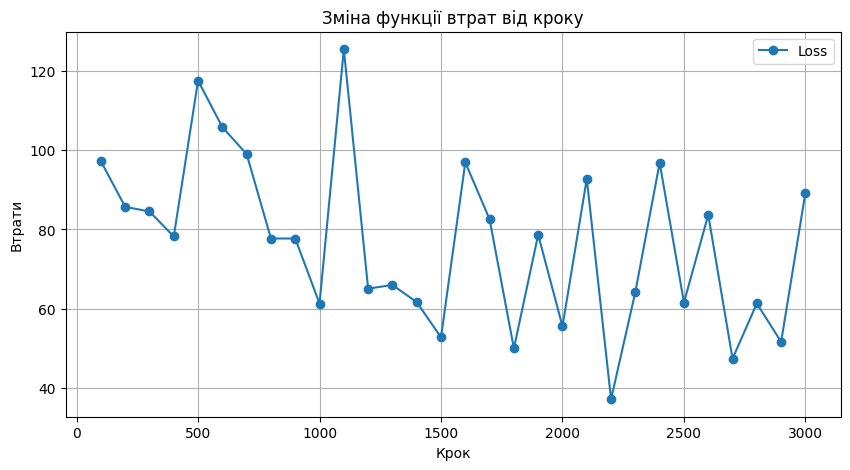

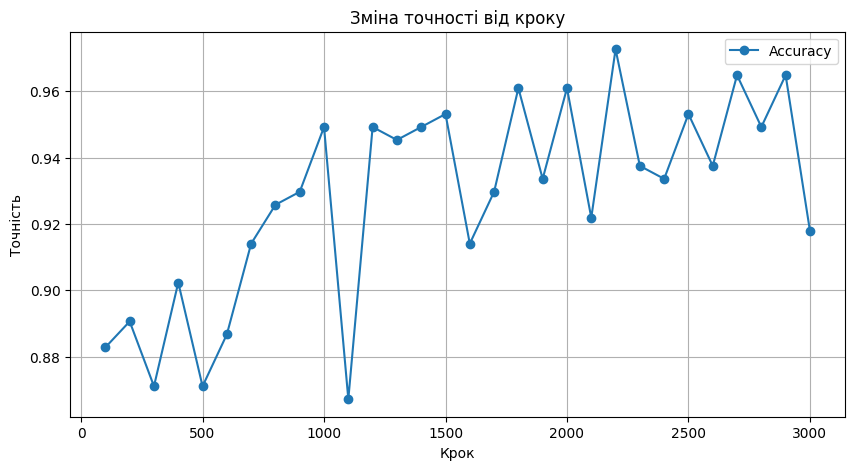

In [29]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(display_step, training_steps + 1, display_step), loss_history, marker='o', label='Loss')
plt.title('Зміна функції втрат від кроку')
plt.xlabel('Крок')
plt.ylabel('Втрати')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(display_step, training_steps + 1, display_step), accuracy_history, marker='o', label='Accuracy')
plt.title('Зміна точності від кроку')
plt.xlabel('Крок')
plt.ylabel('Точність')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
test_predictions = neural_net(x_test)

predicted_classes = tf.argmax(test_predictions, axis=1)

test_accuracy = accuracy(test_predictions, y_test)
print(f'Точність навченої нейромережі на тестових даних: {test_accuracy.numpy()}')

print(classification_report(y_test, predicted_classes, digits=4))

Точність навченої нейромережі на тестових даних: 0.9375
              precision    recall  f1-score   support

           0     0.9506    0.9816    0.9659       980
           1     0.9823    0.9762    0.9792      1135
           2     0.9292    0.9409    0.9350      1032
           3     0.9296    0.9287    0.9292      1010
           4     0.9374    0.9308    0.9341       982
           5     0.9474    0.9081    0.9273       892
           6     0.9453    0.9562    0.9507       958
           7     0.9407    0.9251    0.9328      1028
           8     0.8561    0.9466    0.8991       974
           9     0.9608    0.8751    0.9160      1009

    accuracy                         0.9375     10000
   macro avg     0.9379    0.9369    0.9369     10000
weighted avg     0.9386    0.9375    0.9375     10000



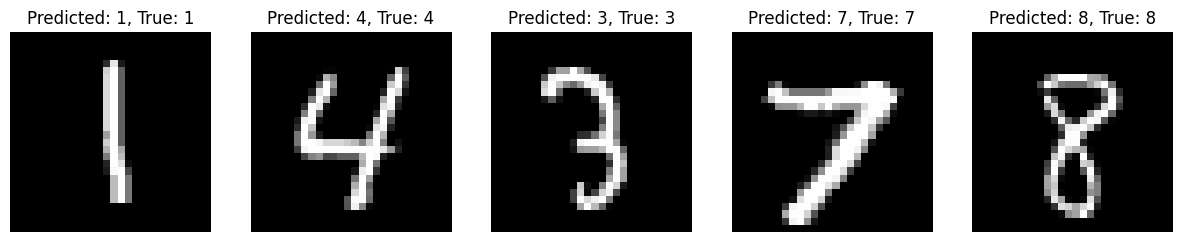

In [34]:
random_indices = random.sample(range(len(x_test)), 5)
images_to_test = x_test[random_indices]
labels_to_test = y_test[random_indices]

# Отримання прогнозів нейромережі для цих зображень
predictions = neural_net(images_to_test)
predicted_labels = np.argmax(predictions, axis=1)

# Виведення зображень разом з відповіддю нейромережі
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images_to_test[i].reshape(28, 28), cmap='gray')
    plt.title(f'Predicted: {predicted_labels[i]}, True: {labels_to_test[i]}')
    plt.axis('off')
plt.show()


**Згідно звіту classification_report і візуалізації експерименту, нейронна мережа погано роспізнає цифру "8" і має точність 93,75%, помиляючись у 6,25% випадків.**